In [1]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 64.2 MB/s 


In [2]:
import SimpleITK as sitk
import os
import numpy as np

import sys
import random

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [3]:
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Input, Cropping2D, Flatten, UpSampling2D, BatchNormalization
from keras.models import Model
from tensorflow import keras
import tensorflow as tf

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Modelo U-NET2

In [5]:
model2 = keras.models.Sequential([
    keras.layers.Input(shape=(256,256,3)),                                 
    #D1                            
    keras.layers.Conv2D(48, (3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Conv2D(48, (3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2, padding='same'),
    #D2
    keras.layers.Conv2D(96,(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Conv2D(96, (3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2, padding='same'),
    #D3
    keras.layers.Conv2D(192,(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Conv2D(192, (3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2, padding='same'),
    #D4
    keras.layers.Conv2D(384,(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Conv2D(384, (3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2, padding='same'),
    #D5
    keras.layers.Conv2D(768,(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Conv2D(768, (3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),

    #U1
    keras.layers.Conv2DTranspose(384,(2,2), strides=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Conv2D(384,(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Conv2D(384,(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    #U2
    keras.layers.Conv2DTranspose(192,(2,2), strides=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Conv2D(192,(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Conv2D(192,(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    #U3
    keras.layers.Conv2DTranspose(96,(2,2), strides=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Conv2D(96,(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Conv2D(96,(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    #U4
    keras.layers.Conv2DTranspose(48,(2,2), strides=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Conv2D(48,(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Conv2D(48,(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    #SEG
    keras.layers.Conv2D(4,(1,1), activation ='softmax'),
])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 48)      1344      
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 48)     192       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 254, 254, 48)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 48)      20784     
                                                                 
 batch_normalization_1 (Batc  (None, 252, 252, 48)     192       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 252, 252, 48)      0

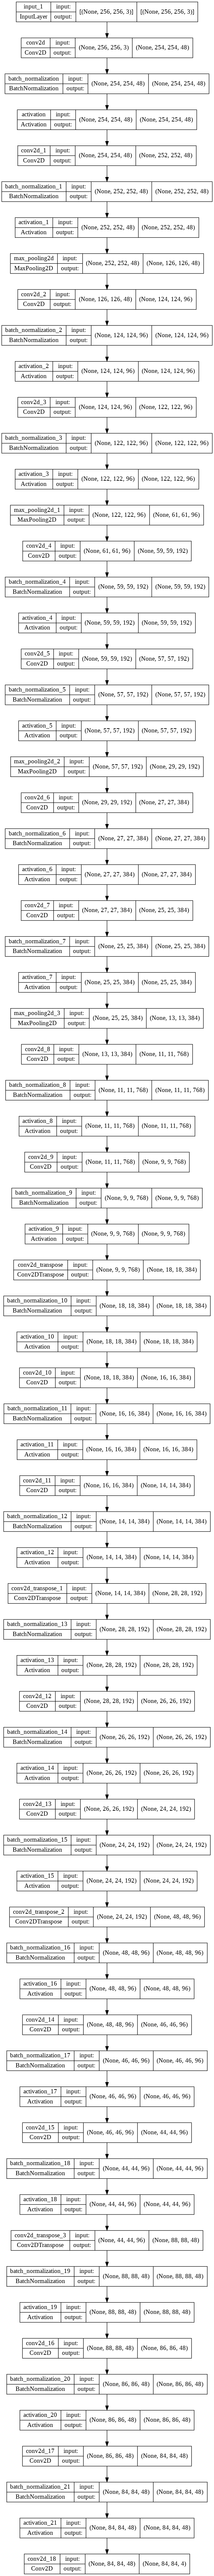

In [6]:
input_shape=(256,256,3)
model2.build(input_shape)
model2.summary()
keras.utils.plot_model(model2, to_file = "Model.png", show_shapes=True)

In [7]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### No modelo U-net 1 a imagem de entrada tem que ter as dimensões: (None, 256,256,3)
### A imagem que sai (mascara) tem de dimensões: (None, 32,32,4)

#Paciente 1

In [ ]:
dataset_dir='/content/drive/MyDrive/testing1/patient0001'
# Path to mhd images (not gt)
image_ids = []
# r=root, d=directories, f = files
for r, d, f in os.walk(dataset_dir):
    for file in f:    
        if ('ED.mhd' in file) or ('ES.mhd' in file):
            image_ids.append(os.path.join(r, file))

image_ids.sort()
images=[]
for image in image_ids:
  #plt.figure(figsize=(12,8))
  #plt.subplot(141)
  image=sitk.GetArrayFromImage(sitk.ReadImage(image,sitk.sitkFloat32))
  image = image[0,:,:] #2D grayscale image
  image=cv2.resize(image,(256,256))
  image=image/255
  image_f=np.stack((image,image,image),axis=2)
  #plt.imshow(image_f)
  images.append(image_f)
  #plt.show()


image_dataset=np.array(images)

['/content/drive/MyDrive/testing1/patient0001/patient0001_2CH_ED_gt0.mhd', '/content/drive/MyDrive/testing1/patient0001/patient0001_2CH_ES_gt0.mhd', '/content/drive/MyDrive/testing1/patient0001/patient0001_4CH_ED_gt0.mhd', '/content/drive/MyDrive/testing1/patient0001/patient0001_4CH_ES_gt0.mhd']


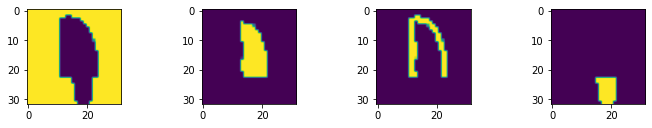

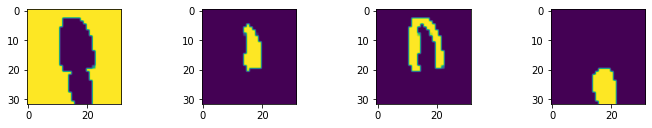

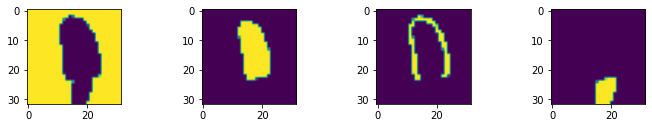

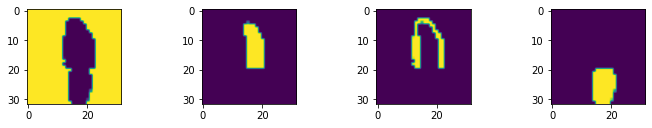

In [ ]:
dataset_dir='/content/drive/MyDrive/testing1/patient0001'
# Path to mhd images (not gt)
mask0_ids = []
mask1_ids = []
mask2_ids = []
mask3_ids = []
# r=root, d=directories, f = files
for r, d, f in os.walk(dataset_dir):
    for file in f:    
        if ('ED.mhd' in file) or ('ES.mhd' in file):
            mask0_ids.append(os.path.join(r, file)[:-4]+"_gt0.mhd")
            mask1_ids.append(os.path.join(r, file)[:-4]+"_gt1.mhd")
            mask2_ids.append(os.path.join(r, file)[:-4]+"_gt2.mhd")
            mask3_ids.append(os.path.join(r, file)[:-4]+"_gt3.mhd")
      
mask0_ids.sort()
print(mask0_ids)
mask1_ids.sort()
mask2_ids.sort()
mask3_ids.sort()
masks=[]

for i in range(4):

  plt.figure(figsize=(12,8))
  plt.subplot(441)
  mask0_1=sitk.GetArrayFromImage(sitk.ReadImage(mask0_ids[i],sitk.sitkFloat32))
  mask0_2=cv2.resize(mask0_1,(32,32))
  plt.imshow(mask0_2)
  plt.subplot(442)
  mask1_1=sitk.GetArrayFromImage(sitk.ReadImage(mask1_ids[i],sitk.sitkFloat32))
  mask1_2=cv2.resize(mask1_1,(32,32))
  plt.imshow(mask1_2)
  plt.subplot(443)
  mask2_1=sitk.GetArrayFromImage(sitk.ReadImage(mask2_ids[i],sitk.sitkFloat32))
  mask2_2=cv2.resize(mask2_1,(32,32))
  plt.imshow(mask2_2)
  plt.subplot(444)
  mask3_1=sitk.GetArrayFromImage(sitk.ReadImage(mask3_ids[i],sitk.sitkFloat32))
  mask3_2=cv2.resize(mask3_1,(32,32))
  plt.imshow(mask3_2)
  plt.show()
  mask_f=np.stack((mask0_2, mask1_2,mask2_2,mask3_2),axis=2)
  masks.append(mask_f)

mask_dataset=np.array(masks)

# Todos os dados de treino

In [8]:
dataset_dir='/content/drive/MyDrive/training'
# Path to mhd images (not gt)
image_ids = []
# r=root, d=directories, f = files
for r, d, f in os.walk(dataset_dir):
    for file in f:    
        if ('ED.mhd' in file) or ('ES.mhd' in file):
            image_ids.append(os.path.join(r, file))

image_ids.sort()
images=[]
for image in image_ids:
  #plt.figure(figsize=(12,8))
  #plt.subplot(141)
  image=sitk.GetArrayFromImage(sitk.ReadImage(image,sitk.sitkFloat32))
  image = image[0,:,:] #2D grayscale image
  image=cv2.resize(image,(256,256))
  image=image/255
  image_f=np.stack((image,image,image),axis=2)
  #plt.imshow(image_f)
  images.append(image_f)
  #plt.show()


image_dataset=np.array(images)

In [9]:
dataset_dir='/content/drive/MyDrive/training'
# Path to mhd images (not gt)
mask0_ids = []
mask1_ids = []
mask2_ids = []
mask3_ids = []
# r=root, d=directories, f = files
for r, d, f in os.walk(dataset_dir):
    for file in f:    
        if ('ED.mhd' in file) or ('ES.mhd' in file):
            mask0_ids.append(os.path.join(r, file)[:-4]+"_gt0.mhd")
            mask1_ids.append(os.path.join(r, file)[:-4]+"_gt1.mhd")
            mask2_ids.append(os.path.join(r, file)[:-4]+"_gt2.mhd")
            mask3_ids.append(os.path.join(r, file)[:-4]+"_gt3.mhd")
      
mask0_ids.sort()
print(mask0_ids)
mask1_ids.sort()
mask2_ids.sort()
mask3_ids.sort()
masks=[]

for i in range(1200):

  #plt.figure(figsize=(12,8))
  #plt.subplot(441)
  mask0_1=sitk.GetArrayFromImage(sitk.ReadImage(mask0_ids[i],sitk.sitkFloat32))
  mask0_2=cv2.resize(mask0_1,(84,84))
  #plt.imshow(mask0_2)
  #plt.subplot(442)
  mask1_1=sitk.GetArrayFromImage(sitk.ReadImage(mask1_ids[i],sitk.sitkFloat32))
  mask1_2=cv2.resize(mask1_1,(84,84))
  #plt.imshow(mask1_2)
  #plt.subplot(443)
  mask2_1=sitk.GetArrayFromImage(sitk.ReadImage(mask2_ids[i],sitk.sitkFloat32))
  mask2_2=cv2.resize(mask2_1,(84,84))
  #plt.imshow(mask2_2)
  #plt.subplot(444)
  mask3_1=sitk.GetArrayFromImage(sitk.ReadImage(mask3_ids[i],sitk.sitkFloat32))
  mask3_2=cv2.resize(mask3_1,(84,84))
  #plt.imshow(mask3_2)
  #plt.show()
  mask_f=np.stack((mask0_2, mask1_2,mask2_2,mask3_2),axis=2)
  masks.append(mask_f)

mask_dataset=np.array(masks)

['/content/drive/MyDrive/training/patient0051/patient0051_2CH_ED_gt0.mhd', '/content/drive/MyDrive/training/patient0051/patient0051_2CH_ES_gt0.mhd', '/content/drive/MyDrive/training/patient0051/patient0051_4CH_ED_gt0.mhd', '/content/drive/MyDrive/training/patient0051/patient0051_4CH_ES_gt0.mhd', '/content/drive/MyDrive/training/patient0052/patient0052_2CH_ED_gt0.mhd', '/content/drive/MyDrive/training/patient0052/patient0052_2CH_ES_gt0.mhd', '/content/drive/MyDrive/training/patient0052/patient0052_4CH_ED_gt0.mhd', '/content/drive/MyDrive/training/patient0052/patient0052_4CH_ES_gt0.mhd', '/content/drive/MyDrive/training/patient0053/patient0053_2CH_ED_gt0.mhd', '/content/drive/MyDrive/training/patient0053/patient0053_2CH_ES_gt0.mhd', '/content/drive/MyDrive/training/patient0053/patient0053_4CH_ED_gt0.mhd', '/content/drive/MyDrive/training/patient0053/patient0053_4CH_ES_gt0.mhd', '/content/drive/MyDrive/training/patient0054/patient0054_2CH_ED_gt0.mhd', '/content/drive/MyDrive/training/pati

In [10]:
xtrain=image_dataset[:1080]
xval=image_dataset[1080:]

In [11]:
ytrain=mask_dataset[:1080]
yval=mask_dataset[1080:]

In [12]:
image_dataset.shape
mask_dataset.shape

(1200, 84, 84, 4)

#Treinar o modelo

In [13]:
history2=model2.fit(xtrain,ytrain, epochs=30,batch_size=32, validation_data=(xval,yval))
model2.save('model2_300val.h5')

Epoch 1/30
34/34 [==============================] - 44s 682ms/step - loss: 1.2157 - accuracy: 0.4709 - val_loss: 1.3973 - val_accuracy: 0.0647
Epoch 2/30
34/34 [==============================] - 17s 487ms/step - loss: 0.6395 - accuracy: 0.8114 - val_loss: 1.5039 - val_accuracy: 0.0886
Epoch 3/30
34/34 [==============================] - 17s 491ms/step - loss: 0.4586 - accuracy: 0.8672 - val_loss: 1.5945 - val_accuracy: 0.0522
Epoch 4/30
34/34 [==============================] - 17s 495ms/step - loss: 0.3639 - accuracy: 0.9032 - val_loss: 1.5859 - val_accuracy: 0.0536
Epoch 5/30
34/34 [==============================] - 17s 497ms/step - loss: 0.2915 - accuracy: 0.9297 - val_loss: 1.4485 - val_accuracy: 0.0552
Epoch 6/30
34/34 [==============================] - 17s 500ms/step - loss: 0.2467 - accuracy: 0.9399 - val_loss: 1.2287 - val_accuracy: 0.4977
Epoch 7/30
34/34 [==============================] - 17s 501ms/step - loss: 0.2181 - accuracy: 0.9466 - val_loss: 1.0487 - val_accuracy: 0.7611

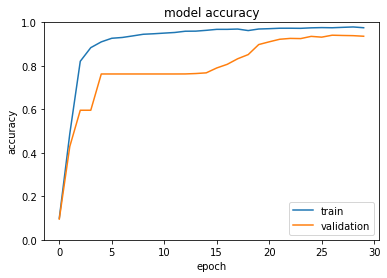

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.ylim([0, 1])
plt.show()

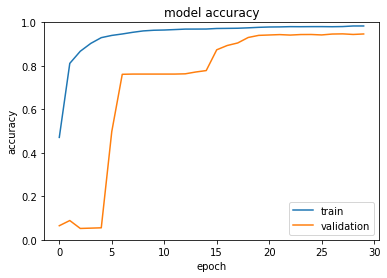

In [14]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.ylim([0, 1])
plt.show()

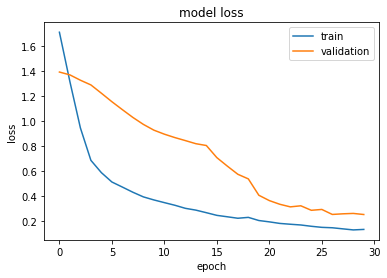

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

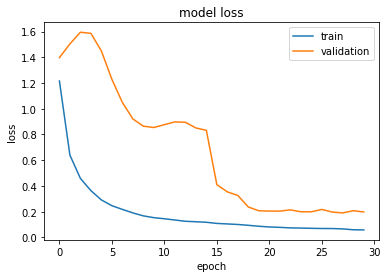

In [15]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Todos os dados de teste

In [16]:
dataset_dir='/content/drive/MyDrive/testing1'
# Path to mhd images (not gt)
image_ids = []
# r=root, d=directories, f = files
for r, d, f in os.walk(dataset_dir):
    for file in f:    
        if ('ED.mhd' in file) or ('ES.mhd' in file):
            image_ids.append(os.path.join(r, file))

image_ids.sort()
images=[]
for image in image_ids:
  #plt.figure(figsize=(12,8))
  #plt.subplot(141)
  image=sitk.GetArrayFromImage(sitk.ReadImage(image,sitk.sitkFloat32))
  image = image[0,:,:] #2D grayscale image
  image=cv2.resize(image,(256,256))
  image=image/255
  image_f=np.stack((image,image,image),axis=2)
  #plt.imshow(image_f)
  images.append(image_f)
  #plt.show()


image_testdataset=np.array(images)

In [17]:
dataset_dir='/content/drive/MyDrive/testing1'
# Path to mhd images (not gt)
mask0_ids = []
mask1_ids = []
mask2_ids = []
mask3_ids = []
# r=root, d=directories, f = files
for r, d, f in os.walk(dataset_dir):
    for file in f:    
        if ('ED.mhd' in file) or ('ES.mhd' in file):
            mask0_ids.append(os.path.join(r, file)[:-4]+"_gt0.mhd")
            mask1_ids.append(os.path.join(r, file)[:-4]+"_gt1.mhd")
            mask2_ids.append(os.path.join(r, file)[:-4]+"_gt2.mhd")
            mask3_ids.append(os.path.join(r, file)[:-4]+"_gt3.mhd")
      
mask0_ids.sort()
print(mask0_ids)
mask1_ids.sort()
mask2_ids.sort()
mask3_ids.sort()
masks=[]

for i in range(200):

  #plt.figure(figsize=(12,8))
  #plt.subplot(441)
  mask0_1=sitk.GetArrayFromImage(sitk.ReadImage(mask0_ids[i],sitk.sitkFloat32))
  mask0_2=cv2.resize(mask0_1,(84,84))
  #plt.imshow(mask0_2)
  #plt.subplot(442)
  mask1_1=sitk.GetArrayFromImage(sitk.ReadImage(mask1_ids[i],sitk.sitkFloat32))
  mask1_2=cv2.resize(mask1_1,(84,84))
  #plt.imshow(mask1_2)
  #plt.subplot(443)
  mask2_1=sitk.GetArrayFromImage(sitk.ReadImage(mask2_ids[i],sitk.sitkFloat32))
  mask2_2=cv2.resize(mask2_1,(84,84))
  #plt.imshow(mask2_2)
  #plt.subplot(444)
  mask3_1=sitk.GetArrayFromImage(sitk.ReadImage(mask3_ids[i],sitk.sitkFloat32))
  mask3_2=cv2.resize(mask3_1,(84,84))
  #plt.imshow(mask3_2)
  #plt.show()
  mask_f=np.stack((mask0_2, mask1_2,mask2_2,mask3_2),axis=2)
  masks.append(mask_f)

mask_testdataset=np.array(masks)

['/content/drive/MyDrive/testing1/patient0001/patient0001_2CH_ED_gt0.mhd', '/content/drive/MyDrive/testing1/patient0001/patient0001_2CH_ES_gt0.mhd', '/content/drive/MyDrive/testing1/patient0001/patient0001_4CH_ED_gt0.mhd', '/content/drive/MyDrive/testing1/patient0001/patient0001_4CH_ES_gt0.mhd', '/content/drive/MyDrive/testing1/patient0002/patient0002_2CH_ED_gt0.mhd', '/content/drive/MyDrive/testing1/patient0002/patient0002_2CH_ES_gt0.mhd', '/content/drive/MyDrive/testing1/patient0002/patient0002_4CH_ED_gt0.mhd', '/content/drive/MyDrive/testing1/patient0002/patient0002_4CH_ES_gt0.mhd', '/content/drive/MyDrive/testing1/patient0003/patient0003_2CH_ED_gt0.mhd', '/content/drive/MyDrive/testing1/patient0003/patient0003_2CH_ES_gt0.mhd', '/content/drive/MyDrive/testing1/patient0003/patient0003_4CH_ED_gt0.mhd', '/content/drive/MyDrive/testing1/patient0003/patient0003_4CH_ES_gt0.mhd', '/content/drive/MyDrive/testing1/patient0004/patient0004_2CH_ED_gt0.mhd', '/content/drive/MyDrive/testing1/pati

#Load do modelo

In [ ]:
from keras.models import load_model
model2 = load_model('/content/drive/MyDrive/ColabNotebooks/model2_val.h5')

In [18]:
results = model2.evaluate(image_testdataset, mask_testdataset, batch_size=32)

7/7 [==============================] - 2s 347ms/step - loss: 0.1976 - accuracy: 0.9456


In [19]:
previs=model2.predict(image_dataset)

In [20]:
previs=model2.predict(image_testdataset)

(84, 84, 4)


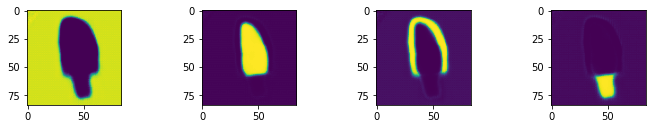

(84, 84, 4)


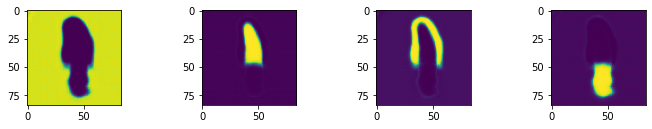

(84, 84, 4)


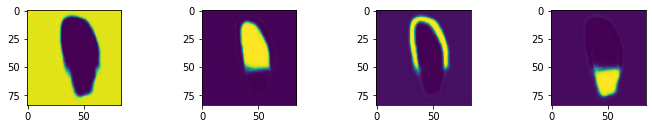

(84, 84, 4)


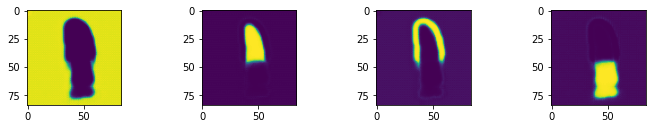

In [ ]:
for i in previs:
  print(i.shape)
  x0=i[:,:,0]
  x1=i[:,:,1]
  x2=i[:,:,2]
  x3=i[:,:,3]
  #print(x.shape)
  plt.figure(figsize=(12,8))
  plt.subplot(441)
  plt.imshow(x0)
  plt.subplot(442)
  plt.imshow(x1)
  plt.subplot(443)
  plt.imshow(x2)
  plt.subplot(444) 
  plt.imshow(x3)
  plt.show()

In [21]:
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice

In [22]:
dice_total=[]
for n in range(200):
  for i in  previs: 
    #print(i.shape)
    pred0=i[:,:,0]
    pred1=i[:,:,1]
    pred2=i[:,:,2]
    pred3=i[:,:,3]
  for f in mask_testdataset:
    y0=f[:,:,0]
    y1=f[:,:,1]
    y2=f[:,:,2]
    y3=f[:,:,3]
  dice1= DICE_COE(pred1,y1)
  #print(dice1)
  dice_total.append(dice1)
  #print(dice_total)
  dice2= DICE_COE(pred2,y2)
  dice_total.append(dice2)
  dice3= DICE_COE(pred3,y3)
  dice_total.append(dice3)

print(dice_total)

[0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826, 0.808, 0.886, 0.826

In [23]:
import statistics
print(max(dice_total))
print(min(dice_total))
print(statistics.mean(dice_total))
print(statistics.pstdev(dice_total))

0.886
0.808
0.84
0.03334666400106613


In [25]:
!pip install hausdorff
from hausdorff import hausdorff_distance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for hausdorff: filename=hausdorff-0.2.6-py3-none-any.whl size=15218 sha256=8c88d70dd321de4aacc69ca371ec7580214e8b08769c26d66361d17501e831a6
  Stored in directory: /root/.cache/pip/wheels/a1/59/b6/af93f52021bdd019edf4673aa46a2407a0e8339f968168df2c
Successfully built hausdorff


In [26]:
dH_total=[]
for n in range(200):
  for i in  previs: 
    #print(i.shape)
    pred0=i[:,:,0]
    pred1=i[:,:,1]
    pred2=i[:,:,2]
    pred3=i[:,:,3]
  for f in mask_testdataset:
    y0=f[:,:,0]
    y1=f[:,:,1]
    y2=f[:,:,2]
    y3=f[:,:,3]
  dH1=hausdorff_distance(pred1,y1)
  dH_total.append(dH1)
  dH2=hausdorff_distance(pred2,y2)
  dH_total.append(dH2)
  dH3=hausdorff_distance(pred3,y3)
  dH_total.append(dH3)
print(dH_total)


[1.7373591516767697, 2.1629987439921914, 1.9451451217280307, 1.7373591516767697, 2.1629987439921914, 1.9451451217280307, 1.7373591516767697, 2.1629987439921914, 1.9451451217280307, 1.7373591516767697, 2.1629987439921914, 1.9451451217280307, 1.7373591516767697, 2.1629987439921914, 1.9451451217280307, 1.7373591516767697, 2.1629987439921914, 1.9451451217280307, 1.7373591516767697, 2.1629987439921914, 1.9451451217280307, 1.7373591516767697, 2.1629987439921914, 1.9451451217280307, 1.7373591516767697, 2.1629987439921914, 1.9451451217280307, 1.7373591516767697, 2.1629987439921914, 1.9451451217280307, 1.7373591516767697, 2.1629987439921914, 1.9451451217280307, 1.7373591516767697, 2.1629987439921914, 1.9451451217280307, 1.7373591516767697, 2.1629987439921914, 1.9451451217280307, 1.7373591516767697, 2.1629987439921914, 1.9451451217280307, 1.7373591516767697, 2.1629987439921914, 1.9451451217280307, 1.7373591516767697, 2.1629987439921914, 1.9451451217280307, 1.7373591516767697, 2.1629987439921914,

In [27]:
print(max(dH_total))
print(min(dH_total))
print(statistics.mean(dH_total))
print(statistics.pstdev(dH_total))

2.1629987439921914
1.7373591516767697
1.9485010057989973
0.17378283786579335


In [ ]:
results = model2.evaluate(image_testdataset, mask_testdataset, batch_size=32)

7/7 [==============================] - 2s 137ms/step - loss: 0.2466 - accuracy: 0.9376
